In [1]:
import dataclasses
import pickle
import random
import numpy as np
from gensim import models

from annoy import AnnoyIndex
from tqdm.notebook import tqdm
from scipy.spatial.distance import euclidean, pdist, squareform
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from typing import *

from scipy.spatial.distance import cosine as cos_dist


In [2]:
"""
def read_glove_file() -> Dict[str, List[float]]:
    #Yields the next 'size' vectors in a glove file.
    glove_file = '/mnt/Spookley/datasets/glove/glove.6B.50d.txt'
    w_vecs = {}
    with tqdm(total=400000) as pbar:
        with open(glove_file) as fh:
            for line in fh.readlines():
                pbar.update(1)
                toks = line.strip().split()
                word = toks[0]
                # non-words like punctuation marks have entries, but we don't want those
                if not word.isalnum():  
                    continue
                # Some bigrams and trigrams are in the dataset. Skip those.
                try:
                    float(toks[1])
                except ValueError:
                    continue
                # No errors, parse the line.
                vec = [float(s) for s in toks[1:]]
                vec = np.array(vec)
                vec = vec / np.linalg.norm(vec)
                vec = vec.tolist()
                w_vecs[word] = vec
    return w_vecs
"""

"\ndef read_glove_file() -> Dict[str, List[float]]:\n    #Yields the next 'size' vectors in a glove file.\n    glove_file = '/mnt/Spookley/datasets/glove/glove.6B.50d.txt'\n    w_vecs = {}\n    with tqdm(total=400000) as pbar:\n        with open(glove_file) as fh:\n            for line in fh.readlines():\n                pbar.update(1)\n                toks = line.strip().split()\n                word = toks[0]\n                # non-words like punctuation marks have entries, but we don't want those\n                if not word.isalnum():  \n                    continue\n                # Some bigrams and trigrams are in the dataset. Skip those.\n                try:\n                    float(toks[1])\n                except ValueError:\n                    continue\n                # No errors, parse the line.\n                vec = [float(s) for s in toks[1:]]\n                vec = np.array(vec)\n                vec = vec / np.linalg.norm(vec)\n                vec = vec.tolist()\n 

In [14]:
def read_goog_file(size=None):
    vec_file = '/home/theo/repos/semantle/GoogleNews-vectors-negative300.bin'
    kv = models.KeyedVectors.load_word2vec_format(vec_file, binary=True, limit=size)
    words = kv.index_to_key
    w_vecs = {}
    for w in words:
        w_vecs[w] = kv[w] / np.linalg.norm(kv[w])
    return w_vecs

In [15]:
def build_index(w_vecs: Dict[str, List[float]]) -> Tuple[Dict[int, str], AnnoyIndex]:
    for v in w_vecs.values():
        GLOVE_VEC_SIZE = len(v)
        break
    idx_to_word = {}
    ann_index = AnnoyIndex(GLOVE_VEC_SIZE, 'euclidean')
    with tqdm(total=len(w_vecs)) as pbar:
        for i, w in enumerate(w_vecs.keys()):
            pbar.update(1)
            ann_index.add_item(i, w_vecs[w])
            idx_to_word[i] = w
    ann_index.build(20) # n trees
    return idx_to_word, ann_index

In [16]:
w_vecs = read_goog_file()
pca = PCA(n_components=100)
mat_full = np.array([w_vecs[w] for w in w_vecs])
mat = pca.fit_transform(mat_full)

print(mat.shape)
for i, w in enumerate(w_vecs.keys()):
    w_vecs[w] = mat[i, :]

(3000000, 100)


In [17]:

idx_to_word, ann_index = build_index(w_vecs)  # fast


  0%|          | 0/3000000 [00:00<?, ?it/s]

In [18]:
print(euclidean(w_vecs['strawberry'], w_vecs['peach']))
print(euclidean(w_vecs['strawberry'], w_vecs['banana']))
print(euclidean(w_vecs['strawberry'], w_vecs['envelope']))

0.5091760158538818
0.6534456014633179
0.8676884770393372


In [19]:
def random_point_in_dist(point, dist):
    # For when we know the dist but have no idea what direction to travel
    vec = np.random.random((len(point)))
    vec = vec / scipy.linalg.norm(vec)
    vec = vec * dist
    return vec+point


def directed_point_in_dist(p1, p2, p1_dist, p2_dist):
    # Generate a vector using p1 and p2.
    # Check if it will point in the general direction of our target.
    p1p2 = (p1-p2)
    p1p2mag = scipy.linalg.norm(p1p2)
    if p1p2mag < 0.00001:
        return None, 0
    p1p2_unit = p1p2 / p1p2mag
    if p1_dist < p2_dist:
        # p1 is closer to target
        mag = p1_dist
        target_point = p1 + p1p2_unit*mag
        confidence = (p2_dist-p1_dist) / p1p2mag
        assert confidence >= 0
    else:
        # j is closer to target
        # make a vector from j to a target that is dists[j] away
        mag = p2_dist
        target_point = p2 - p1p2_unit*mag
        confidence = (p1_dist-p2_dist) / p1p2mag
        assert confidence >= 0
    return target_point, confidence

In [20]:
# test case - target at [0,6], points on y axis
p1 = np.array([0,0])
p2 = np.array([0,2])
target = np.array([0,6])
d1 = euclidean(p1, target)
d2 = euclidean(p2, target)
print('expect [0,6]', directed_point_in_dist(p1, p2, d1, d2))
print('expect [0,6]', directed_point_in_dist(p2, p1, d2, d1))

expect [0,6] (array([0., 6.]), 1.0)
expect [0,6] (array([0., 6.]), 1.0)


In [21]:
# test case - target at [1,3], points on y axis
p1 = np.array([0,0])
p2 = np.array([0,2])
target = np.array([1,3])
d1 = euclidean(p1, target)
d2 = euclidean(p2, target)
print('expect [1,3]', directed_point_in_dist(p1, p2, d1, d2))
print('expect [1,3]', directed_point_in_dist(p2, p1, d2, d1))

expect [1,3] (array([0.        , 3.41421356]), 0.8740320488976422)
expect [1,3] (array([0.        , 3.41421356]), 0.8740320488976422)


In [22]:
# test case - target at [3,1], points on y axis
p1 = np.array([0,0])
p2 = np.array([0,2])
target = np.array([3,1])
d1 = euclidean(p1, target)
d2 = euclidean(p2, target)
print(d1, d2)
print('expect zero confidence', directed_point_in_dist(p1, p2, d1, d2))
print('expect zero confidence', directed_point_in_dist(p2, p1, d2, d1))

3.1622776601683795 3.1622776601683795
expect zero confidence (array([0.        , 5.16227766]), 0.0)
expect zero confidence (array([ 0.        , -3.16227766]), 0.0)


In [23]:
def score_to_dist(score):
    sim_score = score / 100
    coef = [-1.0357972 ,  0.60367754, -0.73071757,  1.14227681]
    # coef = [-0.93024736,  0.28175783, -0.73464682,  1.12342693]  # 100 dims lets goooooo
    return coef[0]*sim_score**3 + coef[1]*sim_score**2 + coef[2]*sim_score + coef[3]

In [54]:
class SemantleGame():
    def __init__(self, w_vecs):
        w_list = list(w_vecs.keys())
        self.target_word = random.choice(w_list[1000:10000])
        self.target_vec = w_vecs[self.target_word]
        
    def guess(self, word, vec) -> Tuple[bool, float]:
        # construct guess
        # dist = euclidean(vec, self.target_vec) lol nope!
        sim_score = 1-cos_dist(vec, self.target_vec)
        dist = score_to_dist(sim_score)
        # check if win
        if word == self.target_word:
            return True, dist, sim_score
        else:
            return False, dist, sim_score
    
    def display_guesses(self):
        s = []
        for g in sorted(self.guesses, key = lambda g: g.dist):
            s.append(str(g))
        print('\n'.join(s))
        
    def __str__(self):
        return '\n'.join('{}: {}'.format(k, v) for k, v in self.__dict__.items())

In [61]:
@dataclasses.dataclass
class Guess:
    word: str
    num: int
    dist: float
    score: float
    
class SemantleSolver:
    
    def __init__(self, n_random_guesses=2, game=None, conf_thresh=0.1):
        self.n_random_guesses = n_random_guesses
        self.closest_dist = float('inf')
        self.guesses = []  # List[Guess]
        self.guessed_words = set()  # for fast lookup
        self.best_guess = None
        self.game = game
        
        self.N_RANDOM = 5
        self.CONF_THRESH = conf_thresh
        
        self.stats = {
            'grd_high_conf': 0,
            'grd_random_dist': 0,
            'times_gradient': 0,
            'times_exhaustive': 0,
            'times_random': 0,
        }
        
    def _gradient_method(self, w_vecs, ann_index):
        # Use gradient method to get a closer guess.
        p1 = np.array(w_vecs[self.guesses[-1].word])
        p1_dist = self.guesses[-1].dist
        
        # Consider the few most recent points. 
        # Try and find one with a vector through p1 that points towards the target.
        best_point = None
        best_confidence = 0
        best_p2_dist = float('inf')
        for i in range(2, min(10, len(self.guesses))):
            p2 = np.array(w_vecs[self.guesses[-i].word])
            p2_dist = self.guesses[-i].dist
            
            # where does p2->p1 point? and how well aligned is that spot with the target?
            target_point, confidence = directed_point_in_dist(p1, p2, p1_dist, p2_dist)
            if confidence > best_confidence:
                best_confidence = confidence
                best_point = target_point
        if best_confidence < self.CONF_THRESH:
            self.stats['grd_random_dist'] += 1
            vec = np.array(w_vecs[self.best_guess])
            best_point = random_point_in_dist(vec, self.closest_dist)
            #print('grd_rand')
        else:
            self.stats['grd_high_conf'] += 1
            #print('grd_conf')

        return best_point

    
    def find_next_guess(self, w_vecs, ann_index, idx_to_word) -> bool:
        if len(self.guesses) < self.N_RANDOM:
            self.stats['times_random'] += 1
            next_word = random.choice(list(w_vecs.keys()))
        else:
            self.stats['times_gradient'] += 1
            v = self._gradient_method(w_vecs, ann_index)
            idxs_near_best = ann_index.get_nns_by_vector(v, 1000)
            for idx in idxs_near_best:
                w = idx_to_word[idx]
                if w not in self.guessed_words:
                    next_word = w
                    break
            
        return next_word

    def make_guess(self, word):
        # guess the word
        win, dist, sim_score = self.game.guess(word, w_vecs[word])
        self.guessed_words.add(word)
        self.guesses.append(Guess(word=word, dist=dist, num=len(self.guesses)+1, score=sim_score*100))
        
        # see if this one's better
        if self.best_guess is None or dist < self.closest_dist:
            #print(word, round(dist, 3))
            self.closest_dist = dist
            self.best_guess = word
        
        if win:
            #print("I win!")
            return True
        else:
            return False
    
    def add_guess(self, word, score):
        # Adds a guess from an external source. For playing Real Semantle.
        dist = score_to_dist(score)
        self.guessed_words.add(word)
        self.guesses.append(Guess(word=word, dist=dist, num=len(self.guesses)+1, score=score*100))
        if self.best_guess is None or dist < self.closest_dist:
            #print(word, round(dist, 3))
            self.closest_dist = dist
            self.best_guess = word
        

smallest
0.001
stopped. 
Best guess: shrunk dist: 1.137191789672184
{'grd_high_conf': 934, 'grd_random_dist': 62, 'times_gradient': 996, 'times_exhaustive': 0, 'times_random': 5}


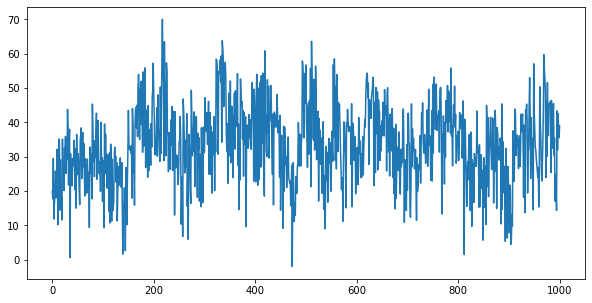

In [92]:
game = SemantleGame(w_vecs)
player = SemantleSolver(game=game, conf_thresh=0.001)
print(game.target_word)
print(player.CONF_THRESH)
won = False 
while not won:
    word = player.find_next_guess(w_vecs, ann_index, idx_to_word)
    won = player.make_guess(word)
    g = player.guesses[-1]
    #print(g.word, round(g.dist, 3))
    if len(player.guesses) > 1000:
        print('stopped. ')
        print('Best guess:', player.best_guess, 'dist:', player.closest_dist)
        break

print(player.stats)
traj = [g.score for g in player.guesses]

plt.figure(figsize=(10,5))
plt.plot(range(len(traj)), traj, '-')

In [ ]:
# grid search time.
def run_trial(exh, n_rand, conf_thresh, w_vecs, idx_to_word, ann_index):
    # make a game
    
    game = SemantleGame(w_vecs)
    player = SemantleSolver(game=game)
    
    player.EXH_THRESH = exh
    player.N_RANDOM = n_rand
    player.CONF_THRESH = conf_thresh
    
    won = False
    while not won:
        word = player.find_next_guess(w_vecs, ann_index, idx_to_word)
        won = player.make_guess(word)
        if len(player.guesses) > 1000:
            break
    return len(player.guesses)

In [ ]:

n_dims = [10, 15, 20]
exh_threshes = [0.001]
n_randoms = [3]
conf_threshes = [0.2, 0.3, 0.4, 0.6, 0.8]
n_trials = 20

params_results = {}

for n_dim in n_dims:
    
    # set up space
    w_vecs = read_glove_file()
    pca = PCA(n_components=n_dim)
    mat_full = np.array([w_vecs[w] for w in w_vecs])
    mat = pca.fit_transform(mat_full)

    for i, w in enumerate(w_vecs.keys()):
        w_vecs[w] = mat[i, :]

    idx_to_word, ann_index = build_index(w_vecs)

    
    for exh in exh_threshes:
        for n_rand in n_randoms:
            for conf_thresh in conf_threshes:
                params = (n_dim, exh, n_rand, conf_thresh)
                for trial in range(n_trials):
                    n_guesses = run_trial(exh, n_rand, conf_thresh, w_vecs, idx_to_word, ann_index)
                    if not params in params_results:
                        params_results[params] = 0
                    params_results[params] += n_guesses
                params_results[params] /= n_trials
                print(params, params_results[params])

print(params_results)

In [ ]:
print(list(sorted(zip(params_results.items()), key=lambda x: x[1]))[:10])

In [ ]:
ls = list(sorted(zip(params_results.items()), key = lambda x: x[0][1]))

In [ ]:
for item in ls:
    print(item)

In [ ]:
# Now make something that plays Real Semantle
s_play = SemantleSolver()
s_play.CONF_THRESH = 0.2
s_play.add_guess('surrey', 8.11)
s_play.add_guess('injurying', -6.47)
s_play.add_guess('xxx_domain_name', 23.52)
s_play.add_guess('Program_TM_QuickAir', 4.12)
s_play.add_guess('Onlookers', 5.27)
s_play.add_guess('XXX_domain', 19.36)
s_play.add_guess('domain_suffix', 23.19)
s_play.add_guess('domain_suffixes', 16.66)
s_play.add_guess('antivirus_vendors', 14.57)
s_play.add_guess('Firefox_extensions', 26.94)
s_play.add_guess('Firefox_add_ons', 33.49)
s_play.add_guess('FireFox', 20.56)
s_play.add_guess('slashtags', 31.54)
s_play.add_guess('sitelinks', 35.35)
s_play.add_guess('backlink', 22.18)
s_play.add_guess('Macrumors', 21.93)
s_play.add_guess('keyphrases', 15.95)
s_play.add_guess('screenshot', 33.78)
s_play.add_guess('screengrab', 23.42)
s_play.add_guess('screenshots', 21.49)
s_play.add_guess('favicon', 45.82)
s_play.add_guess('menubar', 48.45)
s_play.add_guess('Downloads_folder', 41.77)
s_play.add_guess('Applications_folder', 36.37)
s_play.add_guess('scrollbar', 48.03)
s_play.add_guess('toolbar_buttons', 46.15)
s_play.add_guess('dialog_boxes', 42.41)
s_play.add_guess('filetype', 38.06)
s_play.add_guess('Passively', 25.72)
s_play.add_guess('Start_Menu', 43.70)
s_play.add_guess('shortcut_keys', 57.59)
s_play.add_guess('homescreens', 46.41)
s_play.add_guess('hotkeys', 56.43)
s_play.add_guess('hotkey', 58.91)
s_play.add_guess('keyboard_shortcut', 56.36)
s_play.add_guess('Ctrl_+', 55.19)
s_play.add_guess('CTRL_+', 52.57)
s_play.add_guess('ctrl', 48.02)
s_play.add_guess('thumbstick', 52.04)
s_play.add_guess('d_pad', 55.63)
s_play.add_guess('arrow_keys', 54.87)
s_play.add_guess('cursor', 54.05)
s_play.add_guess('spacebar', 68.31)
s_play.add_guess('stylus', 45.48)
s_play.add_guess('Fn_key', 62.21)
s_play.add_guess('shortcut_buttons', 55.77)
s_play.add_guess('Spacebar', 55.94)
s_play.add_guess('mouse_buttons', 49.41)
s_play.find_next_guess(w_vecs, ann_index, idx_to_word)
